### Subsetting sensitivities, training on GPU and GP Regression with LOVE

This notebook will look at a couple topics. First, it will run the exact GP method for GPU on a subset of the data. Next, it will try to implement a fast GP regression with LOVE, and examine the accuracy and efficiency for that. Finally, as these examples are built on subsetted portions of a full dataset, I will aim to examine the impact on efficiency/accuracy of subsetted data size.

### Setting up the environment and loading in the data

Adapted from [here](https://discuss.pytorch.org/t/dataloader-parallelization-synchronization-with-zarr-xarray-dask/176149).

In [1]:
!pip install torch tqdm gpytorch
!pip install xbatcher

  Obtaining dependency information for gpytorch from https://files.pythonhosted.org/packages/12/24/805d9a4fcb5d105b95b2dac56d0764cfcceba31319437ca94a6592552f84/gpytorch-1.11-py3-none-any.whl.metadata
  Using cached gpytorch-1.11-py3-none-any.whl.metadata (7.4 kB)
  Obtaining dependency information for linear-operator>=0.5.0 from https://files.pythonhosted.org/packages/4e/3b/c86ec0c226763a2a199b370f50309ef58c0d8c1555e6a278bd053263881f/linear_operator-0.5.2-py3-none-any.whl.metadata
  Using cached linear_operator-0.5.2-py3-none-any.whl.metadata (15 kB)
  Obtaining dependency information for jaxtyping>=0.2.9 from https://files.pythonhosted.org/packages/1f/8f/90f81553044a40c56e546b24de94cafd0a7549ee0361ec39882c5e2abb15/jaxtyping-0.2.23-py3-none-any.whl.metadata
  Using cached jaxtyping-0.2.23-py3-none-any.whl.metadata (6.4 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)
Using cached gpytorch-1.11-py3-none-any.whl (266 kB)
Using cached linear_operator-0.5.2-py3-none-any.whl (17

In [2]:
import numpy as np
import gpytorch
import xarray as xr
import xbatcher
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
import math
import matplotlib.pyplot as plt

In [3]:
#from dask.distributed import Client

#client = Client("tcp://127.0.0.1:43471")
#client

In [4]:
# Open the dataset
baker_url = 's3://petrichor/geosmart/baker.zarr/'
baker_ds = xr.open_dataset(
    baker_url, chunks='auto', engine='zarr', storage_options={"anon": True}
)

In [5]:
baker_ds

<xarray.Dataset>
Dimensions:      (time: 55, y: 12089, x: 11383)
Coordinates:
  * time         (time) datetime64[ns] 1947-09-14 1950-09-02 ... 2020-12-12
  * x            (x) float64 5.809e+05 5.809e+05 ... 5.923e+05 5.923e+05
  * y            (y) float64 5.409e+06 5.409e+06 ... 5.397e+06 5.397e+06
Data variables:
    band1        (time, y, x) float32 dask.array<chunksize=(55, 712, 670), meta=np.ndarray>
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area
    add_offset:     0.0
    crs:            PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS...
    scale_factor:   1.0

In [6]:
bgen = iter(xbatcher.BatchGenerator(baker_ds, {"x": 50, "y": 50, "time": 55}))
chunk = next(bgen)

We are now at a state where the dataset is in chunks

### Train model with the tensor

Copied from [here](https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html)

In [11]:
# Creating generate test data
#max_elem_count = 10000
df = chunk.band1.to_dataframe().dropna().reset_index()
df['time'] = (df['time'] - df['time'].min())  / np.timedelta64(1,'D')
df_numpy = df.to_numpy(dtype=np.float64)

X_train = torch.from_numpy(df_numpy[:15000,:-1]/np.mean(df_numpy[0:10000,:-1])).float()
Y_train = torch.from_numpy(df_numpy[:15000,-1]/np.mean(df_numpy[0:10000,-1])).float()
X_test = torch.from_numpy(df_numpy[15000:16000,:-1]/np.mean(df_numpy[10000:12000,:-1])).float()
Y_test = torch.from_numpy(df_numpy[15000:16000,-1]/np.mean(df_numpy[10000:12000,-1])).float()
#chunk_sparse = np.random.choice(range(len(Y)), max_elem_count, replace=False)

#X_train,Y_train,X_test,Y_test

In [12]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
#X_train,Y_train,X_test,Y_test = generate_tensor(chunk)
model = ExactGPModel(X_train.cuda(), Y_train.cuda(), likelihood.cuda())

In [13]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [14]:
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model.cuda())

training_iter = 50

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train.cuda())
    # Calc loss and backprop gradients
    loss = -mll(output, Y_train.cuda())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.736   lengthscale: 0.693   noise: 0.693


/srv/conda/envs/notebook/lib/python3.11/site-packages/linear_operator/operators/added_diag_linear_operator.py:128: NumericalWarning: NaNs encountered in preconditioner computation. Attempting to continue without preconditioning.
  warnings.warn(


Iter 2/50 - Loss: 0.700   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.663   lengthscale: 0.797   noise: 0.598
Iter 4/50 - Loss: 0.625   lengthscale: 0.849   noise: 0.554
Iter 5/50 - Loss: 0.586   lengthscale: 0.901   noise: 0.513
Iter 6/50 - Loss: 0.546   lengthscale: 0.952   noise: 0.474
Iter 7/50 - Loss: 0.506   lengthscale: 1.002   noise: 0.437
Iter 8/50 - Loss: 0.465   lengthscale: 1.048   noise: 0.403
Iter 9/50 - Loss: 0.423   lengthscale: 1.092   noise: 0.370
Iter 10/50 - Loss: 0.380   lengthscale: 1.129   noise: 0.340
Iter 11/50 - Loss: 0.337   lengthscale: 1.158   noise: 0.312
Iter 12/50 - Loss: 0.293   lengthscale: 1.178   noise: 0.286
Iter 13/50 - Loss: 0.249   lengthscale: 1.187   noise: 0.261
Iter 14/50 - Loss: 0.204   lengthscale: 1.185   noise: 0.239
Iter 15/50 - Loss: 0.158   lengthscale: 1.172   noise: 0.218
Iter 16/50 - Loss: 0.112   lengthscale: 1.148   noise: 0.199
Iter 17/50 - Loss: 0.065   lengthscale: 1.114   noise: 0.181
Iter 18/50 - Loss: 0.018   lengt

/srv/conda/envs/notebook/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iter 32/50 - Loss: -0.681   lengthscale: 0.351   noise: 0.041
Iter 33/50 - Loss: -0.732   lengthscale: 0.316   noise: 0.037
Iter 34/50 - Loss: -0.783   lengthscale: 0.285   noise: 0.033
Iter 35/50 - Loss: -0.835   lengthscale: 0.259   noise: 0.030
Iter 36/50 - Loss: -0.886   lengthscale: 0.239   noise: 0.027
Iter 37/50 - Loss: -0.938   lengthscale: 0.224   noise: 0.024
Iter 38/50 - Loss: -0.990   lengthscale: 0.211   noise: 0.022
Iter 39/50 - Loss: -1.041   lengthscale: 0.200   noise: 0.020
Iter 40/50 - Loss: -1.093   lengthscale: 0.190   noise: 0.018
Iter 41/50 - Loss: -1.144   lengthscale: 0.183   noise: 0.016
Iter 42/50 - Loss: -1.196   lengthscale: 0.176   noise: 0.014
Iter 43/50 - Loss: -1.247   lengthscale: 0.171   noise: 0.013
Iter 44/50 - Loss: -1.298   lengthscale: 0.165   noise: 0.012
Iter 45/50 - Loss: -1.349   lengthscale: 0.159   noise: 0.010
Iter 46/50 - Loss: -1.400   lengthscale: 0.154   noise: 0.009
Iter 47/50 - Loss: -1.450   lengthscale: 0.149   noise: 0.009
Iter 48/

In [15]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test.cuda()))

In [16]:
observed_pred.mean.cpu()

tensor([0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973,
        0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973,
        0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973,
        0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973,
        0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973,
        0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973,
        0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973,
        0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973,
        0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973,
        0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973,
        0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973,
        0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973,
        0.9973, 0.9973, 0.9973, 0.9973, 

Text(0, 0.5, 'Predicted elevation [m]')

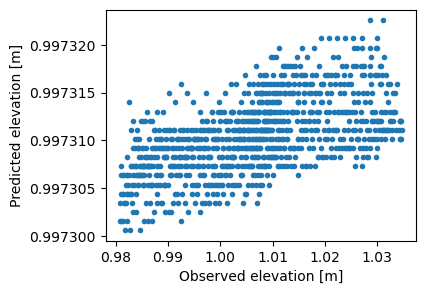

In [17]:
f, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(Y_test.numpy(),observed_pred.mean.cpu().numpy(),linestyle='None',marker='.')
#ax.plot([650,1000],[650,1000])
#ax.set_xlim([650,1000])
#ax.set_ylim([500,1000])
ax.set_xlabel('Observed elevation')
ax.set_ylabel('Predicted elevation')

### Let's try using GP Regression with LOVE

In [23]:
class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self, input_dim):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(input_dim, 1000))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(1000, 500))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(500, 50))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(50, 2))


class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            grid_size=100, num_dims=2,
        )

        # Also add the deep net
        self.feature_extractor = LargeFeatureExtractor(input_dim=train_x.size(-1))

    def forward(self, x):
        # We're first putting our data through a deep net (feature extractor)
        # We're also scaling the features so that they're nice values
        projected_x = self.feature_extractor(x)
        projected_x = projected_x - projected_x.min(0)[0]
        projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

        # The rest of this looks like what we've seen
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(X_train.cuda(), Y_train.cuda(), likelihood.cuda())

model = model.cuda()
likelihood = likelihood.cuda()

In [24]:
training_iterations = 20


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


def train():
    iterator = tqdm(range(training_iterations))
    for i in iterator:
        optimizer.zero_grad()
        output = model(X_train.cuda())
        loss = -mll(output, Y_train.cuda())
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()

%time train()

100%|██████████| 20/20 [03:37<00:00, 10.88s/it, loss=-.0784]

CPU times: user 3min 38s, sys: 188 ms, total: 3min 38s
Wall time: 3min 37s


In [25]:
import time

# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    start_time = time.time()
    preds = likelihood(model(X_test.cuda()))
    exact_covar = preds.covariance_matrix
    exact_covar_time = time.time() - start_time

print(f"Time to compute exact mean + covariances: {exact_covar_time:.2f}s")

Time to compute exact mean + covariances: 0.81s


In [26]:
# Clear the cache from the previous computations
model.train()
likelihood.train()

# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(100):
    start_time = time.time()
    preds = model(X_test.cuda())
    fast_time_no_cache = time.time() - start_time

In [27]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    start_time = time.time()
    preds = likelihood(model(X_test.cuda()))
    fast_covar = preds.covariance_matrix
    fast_time_with_cache = time.time() - start_time

In [28]:
print('Time to compute mean + covariances (no cache) {:.2f}s'.format(fast_time_no_cache))
print('Time to compute mean + variances (cache): {:.2f}s'.format(fast_time_with_cache))

Time to compute mean + covariances (no cache) 0.17s
Time to compute mean + variances (cache): 0.03s


In [29]:
mae = ((exact_covar - fast_covar).abs() / exact_covar.abs()).mean()
print(f"MAE between exact covar matrix and fast covar matrix: {mae:.6f}")

MAE between exact covar matrix and fast covar matrix: 0.000002


In [30]:
import time
num_samples = 20 


# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    start_time = time.time()
    exact_samples = model(X_test.cuda()).rsample(torch.Size([num_samples]))
    exact_sample_time = time.time() - start_time

print(f"Time to compute exact samples: {exact_sample_time:.2f}s")

Time to compute exact samples: 0.72s


In [31]:
# Clear the cache from the previous computations
model.train()
likelihood.train()

# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(200):
    # NEW FLAG FOR SAMPLING
    with gpytorch.settings.fast_pred_samples():
        start_time = time.time()
        _ = model(X_test.cuda()).rsample(torch.Size([num_samples]))
        fast_sample_time_no_cache = time.time() - start_time

# Repeat the timing now that the cache is computed
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    with gpytorch.settings.fast_pred_samples():
        start_time = time.time()
        love_samples = model(X_test.cuda()).rsample(torch.Size([num_samples]))
        fast_sample_time_cache = time.time() - start_time

print('Time to compute LOVE samples (no cache) {:.2f}s'.format(fast_sample_time_no_cache))
print('Time to compute LOVE samples (cache) {:.2f}s'.format(fast_sample_time_cache))

Time to compute LOVE samples (no cache) 0.43s
Time to compute LOVE samples (cache) 0.01s


In [32]:
# Compute exact posterior covar
with torch.no_grad():
    start_time = time.time()
    posterior = model(X_test.cuda())
    mean, covar = posterior.mean, posterior.covariance_matrix

exact_empirical_covar = ((exact_samples - mean).t() @ (exact_samples - mean)) / num_samples
love_empirical_covar = ((love_samples - mean).t() @ (love_samples - mean)) / num_samples

exact_empirical_error = ((exact_empirical_covar - covar).abs()).mean()
love_empirical_error = ((love_empirical_covar - covar).abs()).mean()

print(f"Empirical covariance MAE (Exact samples): {exact_empirical_error}")
print(f"Empirical covariance MAE (LOVE samples): {love_empirical_error}")

Empirical covariance MAE (Exact samples): 0.002705574268475175
Empirical covariance MAE (LOVE samples): 0.006400780752301216
